### Bellman Optimization

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import time
import matplotlib.pyplot as plt

#### Parameters for MC simulation of stock prices

Geometric Browniam Motion하에서 dynamic stock price를 generating한다

In [2]:
S0 = 100      # initial stock price
mu = 0.05     # drift
sigma = 0.15  # volatility
r = 0.03      # risk-free rate

M = 1         # maturity
T = 24        # number of time steps

N_MC = 1000    # number of paths

delta_t = M / T                # time interval
gamma = np.exp(- r * delta_t)  # discount factor

#### Geometric Brownian Motion Simulation

$T$ 기간의 $N_{MC}$ stock price sample을 GBM을 이용해 생성한다

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

여기서 $Z$ 는 표준 정규분포를 따르는 난수이다

시뮬레이션 된 $S_t$ paths를 기반으로, state variable $X_t$를 아래의 식을 이용해 계산한다

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

또한 다음을 계산하도록 한다

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

여기서 $\Delta\bar{S}_t$는 모든 $\Delta S_t$의 표본평균이다

Plots of 5 stock price $S_t$ and state variable $X_t$ paths are shown below.

make two datasets. the second dataset will be needed below for Double Q-Learning

In [3]:
starttime = time.time()

S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

S_1 = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S_1.loc[:,0] = S0

random number를 생성하고, $S_t$를 계산한다

In [4]:
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))
RN_1 = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])
    S_1.loc[:,t] = S_1.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN_1.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

delta_S_1 = S_1.loc[:,1:T].values - np.exp(r * delta_t) * S_1.loc[:,0:T-1]
delta_S_hat_1 = delta_S_1.apply(lambda x: x - np.mean(x), axis=0)

state variable $X_t$를 계산한다

In [5]:
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S.astype(float))   # delta_t here is due to their conventions
X_1 = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S_1.astype(float)) 

endtime = time.time()
print('\nTime Cost:', endtime - starttime, 'seconds')


Time Cost: 0.033342838287353516 seconds


Plotting 5 stock price $S_t$ and state variable $X_t$ paths

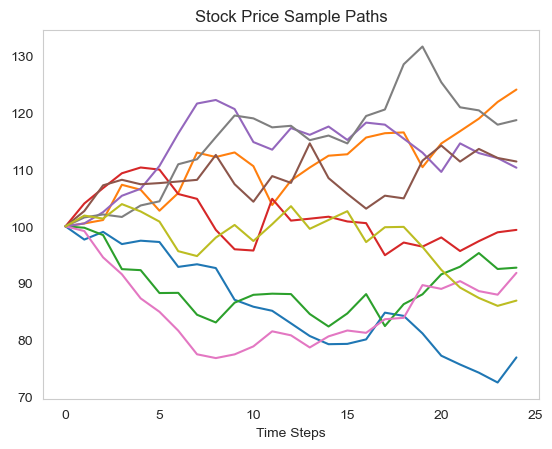

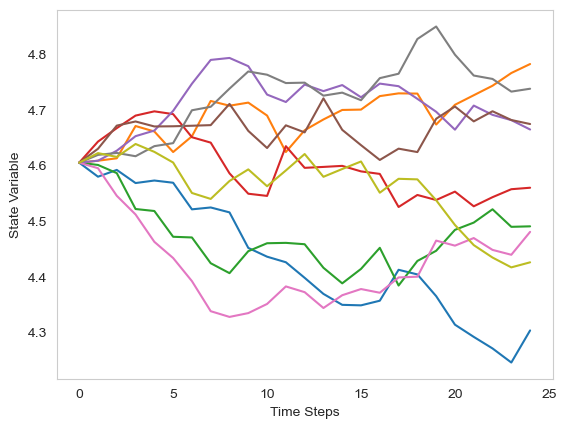

In [9]:
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Time Steps')
plt.grid(False)
plt.title('Stock Price Sample Paths')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.grid(False)
plt.xlabel('Time Steps')
plt.ylabel('State Variable')
plt.show()

European put option의 terminal payoff를 계산하기 위해 `terminal_payoff` 함수를 다음과 같이 정의한다

$$H_T\left(S_T\right)=\max\left(K-S_T,0\right)$$

In [10]:
def terminal_payoff(ST, K):
    # ST   final stock price
    # K    strike
    payoff = max(K - ST, 0)
    return payoff

#### Define spline basis functions

In [12]:
import bspline # import bspline basis function library
import bspline.splinelab as splinelab

X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)

X.shape =  (1000, 25)
X_min, X_max =  4.136175622334782 5.181516486210909


In [13]:
p = 4 # order of spline (as-is; 3: cubic, 4: B-spline?)
ncolloc = 12

These are the sites to which we would like to interpolate

In [14]:
tau = np.linspace(X_min, X_max, ncolloc)

k is a knot vector that adds endpoints repeats as appropriate for a spline of order p. To get meaninful results, one should have ncolloc >= p+1

In [15]:
k = splinelab.aptknt(tau, p) 

Spline basis of order p on knots k

In [17]:
basis = bspline.Bspline(k, p)
print('Number of points k = ', len(k))

Number of points k =  17


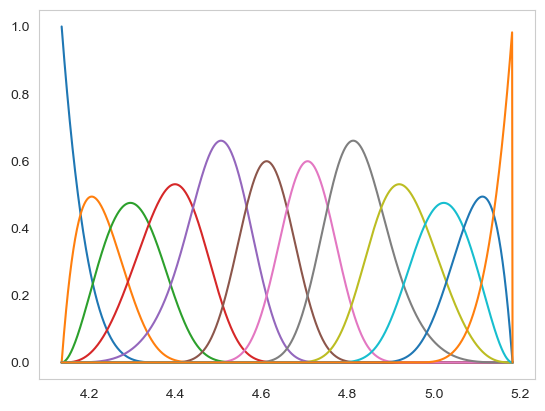

In [22]:
plt.grid(False)
basis.plot()